In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, pairwise

from SentenceEncoder import SentenceEncoder

## Analysis and Processing

In [ ]:
# dataset source: https://github.com/brmson/dataset-sts/tree/master/data/sts/semeval-sts/2015

In [2]:
sentences = pd.read_csv("images.test.tsv", sep="\t", header=None).rename(columns={0:"similarity", 1:"sentence_A", 2:"sentence_B"})
sentences.head()

,similarity,sentence_A,sentence_B
0,NaN,Small dog chews on a big stick.,a dog shews on a big stick.
1,NaN,A tennis player hitting the ball.,Two boys splashing in the surf.
2,NaN,a lone snowboarder in the middle of a snowy gust,A snowboarder is throwing up snow as he rides ...
3,4.4,A pair of dogs playing with a purple ball.,Two dogs play with purple football.
4,0.6,a bird lands in the water.,a boat floats in the water.


In [3]:
sentences.shape

(1500, 3)

In [4]:
# normalizing similarity to cosine range
sentences["similarity"] /= sentences["similarity"].max()

In [5]:
# split into training and test sets
train = sentences[pd.notnull(sentences["similarity"])]
test = sentences[pd.isnull(sentences["similarity"])]

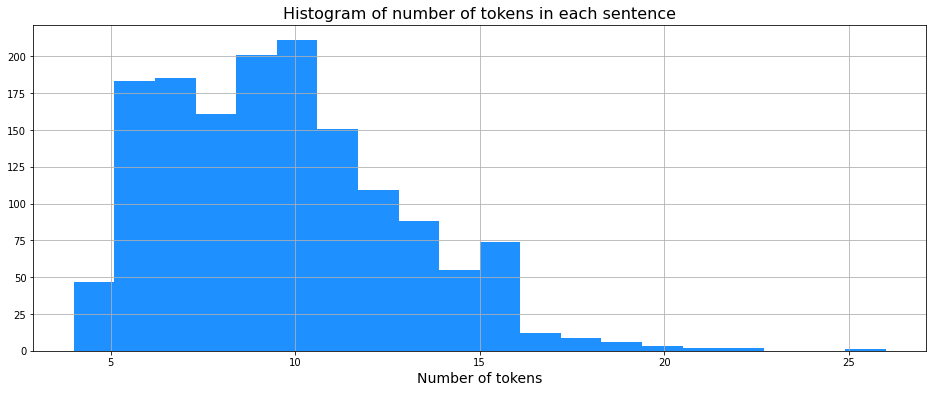

In [6]:
# extracting usual sentence length
training_sentences = pd.concat([train["sentence_A"], train["sentence_B"]]).to_frame().rename(columns={0:"sentences"})

training_sentences["tokens"] = training_sentences["sentences"].apply(lambda x: len(x.split()))
training_sentences["tokens"].hist(bins=20, figsize=(16, 6), color="dodgerblue")
plt.title("Histogram of number of tokens in each sentence", fontsize=16)
plt.xlabel("Number of tokens", fontsize=14)
plt.show()

In [7]:
# extract vocabulary - unique words on the data
vocabulary = list(set((' '.join(training_sentences["sentences"].tolist())).split()))

## Training embedder

In [8]:
s_encoder = SentenceEncoder(vocabulary, max_sentence_length=16, embedding_size=8)

s_encoder.fit([train["sentence_A"], train["sentence_B"]], train["similarity"])

Epoch 1/35
6/6 [==============================] - 7s 13ms/step - loss: 0.2963
Epoch 2/35
6/6 [==============================] - 0s 13ms/step - loss: 0.2167
Epoch 3/35
6/6 [==============================] - 0s 13ms/step - loss: 0.1625
Epoch 4/35
6/6 [==============================] - 0s 13ms/step - loss: 0.1291
Epoch 5/35
6/6 [==============================] - 0s 13ms/step - loss: 0.1090
Epoch 6/35
6/6 [==============================] - 0s 14ms/step - loss: 0.0971
Epoch 7/35
6/6 [==============================] - 0s 13ms/step - loss: 0.0860
Epoch 8/35
6/6 [==============================] - 0s 14ms/step - loss: 0.0775
Epoch 9/35
6/6 [==============================] - 0s 13ms/step - loss: 0.0713
Epoch 10/35
6/6 [==============================] - 0s 13ms/step - loss: 0.0667
Epoch 11/35
6/6 [==============================] - 0s 13ms/step - loss: 0.0603
Epoch 12/35
6/6 [==============================] - 0s 15ms/step - loss: 0.0614
Epoch 13/35
6/6 [==============================] - 0s 14ms/st

In [9]:
def get_similarity(sA, sB):
    embeddings = s_encoder.encode([sA, sB])
    return pairwise.cosine_similarity(embeddings, embeddings)[0, 1]

In [10]:
test.loc[:, "similarity"] = test.loc[:, ["sentence_A", "sentence_B"]].apply(lambda x: get_similarity(x["sentence_A"], x["sentence_B"]), axis=1)

/home/caio/Documents/sentiment-classification/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [11]:
test = test.round(3).sort_values("similarity")

In [12]:
pd.set_option('display.max_colwidth', 1500)

### Similar examples

In [13]:
test.tail(15)

,similarity,sentence_A,sentence_B
460,0.957,Two dogs groom each other.,Two dogs jumping on each other.
187,0.958,A black and white dog is running through the grass.,A black and white dog is jumping in the grass.
231,0.959,A man wearing a red bicycle helmet talking on a cell phone with other people in the background.,A man in a bicycle helmet is talking on a cell phone with other people behind him.
636,0.959,A girl with arms raised in sliding down a red and white slide.,A girl with extended arms goes down a slide.
997,0.960,Two men are racing in the water.,Two young boys playing with ducks near the water.
567,0.966,A swimmer doing the breaststroke in a pool.,A swimmer swimming butterfly in a pool
1247,0.967,A girl in a tie dye hat has a butterfly on her hand.,A girl in a colorful hat has a strange creature resting on her hand.
405,0.967,Two dogs holding one Frisbee in their mouths.,Two dogs holding a single black Frisbee in their mouths
554,0.972,A boy wearing a blue jacket swings a bat at a white ball.,A young boy in a blue jacket swings a bat at a ball.
734,0.973,A black dog with a gemmed collar is sitting on white carpet.,A black dog with a blue collar is sitting on beige carpet.


### "Not" similar examples

In [14]:
test.head(15)

,similarity,sentence_A,sentence_B
1115,-0.402,Two little girls playing on the parallel bars.,The little girl is playing at the playground.
65,-0.398,A black dog bounds through a path in the snow.,Two kids and a dog play in the snow.
1,-0.330,A tennis player hitting the ball.,Two boys splashing in the surf.
164,-0.322,A dog is running through tall grass.,A dig is trekking through snow.
998,-0.284,Brown dog chases after yellow ball in park,Two brown dogs chase each other in the snow.
181,-0.279,Three dogs are playing in the white snow.,A dog is playing in the deep snow.
748,-0.248,A man rollerblading on a metal bar.,Roller blades sliding on a railing.
785,-0.201,A brown dog playing play wrestling with a black dog on snow covered land.,Two dogs playing on snow covered ground
1405,-0.198,Two brown dogs wearing collars fighting.,The brown dog is wearing a black collar.
281,-0.183,A child cavorts on the road.,A white dog runs on the grass.
